In [86]:
!kaggle config set -n username -v aniketk26
!kaggle config set -n key -v e4285a9d92c37f537a3884cd8b7b1c60

!kaggle kernels output -p C:/Users/kambl/Downloads -k textto3d

- username is now set to: aniketk26
- key is now set to: e4285a9d92c37f537a3884cd8b7b1c60
404 - Not Found - Not found


In [87]:
from transformers import DPTImageProcessor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import open3d as o3d


In [88]:
# Load image from local filesystem
image_path = r"C:\Users\kambl\Downloads\generated_image.jpg"
image = Image.open(image_path)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\kambl\\Downloads\\generated_image.jpg'

In [ ]:
processor = DPTImageProcessor.from_pretrained("Intel/dpt-beit-large-512")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-beit-large-512")

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt")

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

In [ ]:
# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

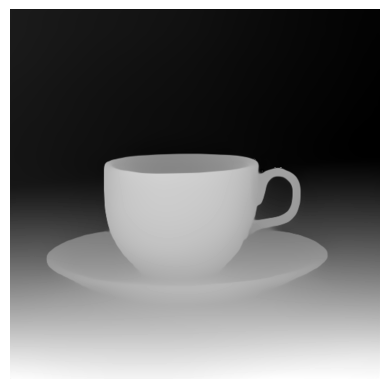

In [ ]:
# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

# for seperate image
# depth.show()

#plot depth map
plt.imshow(depth, cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
# Load depth map and image
depth_map = np.array(depth)
color_image = np.array(image)


In [ ]:
# Define camera intrinsic parameters (example values, replace with actual values)
fx = 1000  # focal length in pixels
fy = 1000
cx = color_image.shape[1] / 2  # principal point (image center)
cy = color_image.shape[0] / 2


In [ ]:
# Generate 3D point cloud with colors
point_cloud = []
colors = []
for v in range(depth_map.shape[0]):
    for u in range(depth_map.shape[1]):
        Z = depth_map[v, u]  # Depth value
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        point_cloud.append([X, Y, Z])
        colors.append(color_image[v, u])

In [ ]:
# Convert colors to [0, 1] range
colors = np.array(colors) / 255.0

# Convert to Open3D point cloud format
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
pcd.colors = o3d.utility.Vector3dVector(colors)



# Visualize point cloud
o3d.visualization.draw_geometries([pcd])